In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from statistics import mean 


In [64]:
# Load data
visit_df = pd.read_csv('Desktop/visit_forcasting_code.csv')

In [65]:
# Extract year and week number
visit_df['year'] = visit_df['WEEK'].astype(str).str[0:4]
visit_df['week_num'] = visit_df['WEEK'].astype(str).str[4:6]
visit_df.rename(columns={'WEEK': 'week_num','VISITORS':'visitors' ,'year': 'year', 'week_num': 'week'}, inplace=True)

visit_df['year'] = visit_df['year'].astype(int)
visit_df['week'] = visit_df['week'].astype(int)

In [66]:
# Calculate cumulative transactions and GMV
visit_df['cum_visits'] = visit_df.groupby(['year'])['visitors'].cumsum()


In [67]:
visit2022 = visit_df[visit_df['year'] == 2022]
visit2023 = visit_df[visit_df['year'] == 2023]


In [68]:
current_week = visit2023['week'].max()
x = 52 - current_week
visit2023=visit2023[visit2023['week'] < current_week]

pred_week_num = np.arange(current_week, 53)
pred_type = ['predicted'] * (x + 1)
pred_year = [2023] * (x + 1)

In [69]:
# Linear Regression Model
model = LinearRegression().fit(visit2023[['week']], visit2023['cum_visits'])
slope = model.coef_[0]
intercept = visit2023['cum_visits'].max()
pred_lm = np.arange(1, x + 2) * slope + intercept

lm_gmv = pd.DataFrame({'pred_year': pred_year, 'pred_week_num': pred_week_num, 'pred_lm': pred_lm, 'pred_type': pred_type})
lm_gmv['cum_lm_visits'] = lm_gmv['pred_lm'].cumsum()

In [70]:
# Year-over-Year comparison

growth_from_2023 = visit2022[visit2022['week'] > current_week-1]['visitors'].cumsum()
pred_visits = growth_from_2023 + visit2023['cum_visits'].max()

short_2022=visit2022[visit2022['week'] < current_week]
new_2022 = short_2022[['week', 'visitors']].copy()

##Finding the difference between the average weekly gmv between last year and this year. Numbers below 
#1 mean that this year is doing
##Better than last year i.e. if we get .7 then we have currently ~70% less than last year at this time, 
#and could expect our WOW model to do 70% worse, so we multiply the WOW growth from 2023 by this value 


YOY_comparison=mean(visit2023['visitors'].values)/mean(new_2022['visitors'].values)
scaled_pred_visits = growth_from_2023 * YOY_comparison + visit2023['cum_visits'].max()


In [71]:
YOY_comparison

0.8041241128444928

In [72]:
pred_df = pd.DataFrame({'year': pred_year, 'week': pred_week_num, 'visits': pred_visits, 'type': pred_type})
scaled_pred_df = pd.DataFrame({'year': pred_year, 'week': pred_week_num, 'visits': scaled_pred_visits, 'type': pred_type})

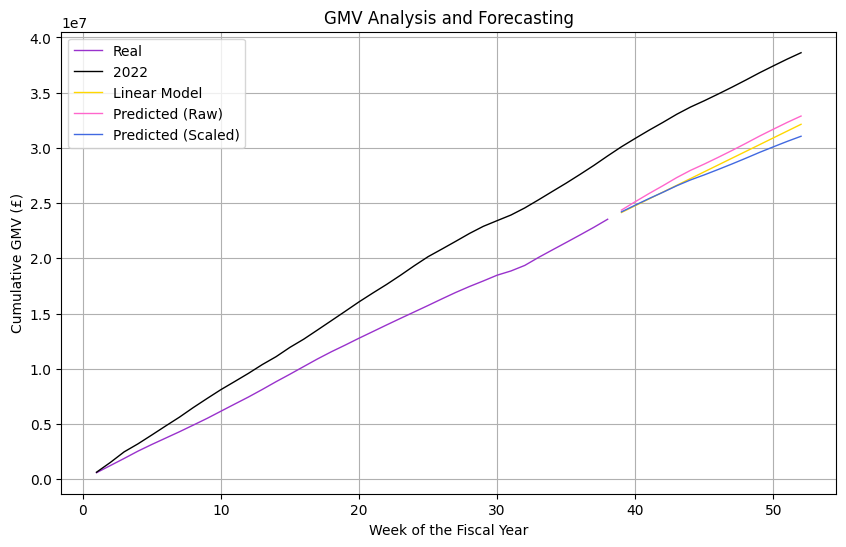

In [73]:
# Plotting GMV
plt.figure(figsize=(10, 6))
plt.plot(visit2023['week'], visit2023['cum_visits'], color="darkorchid", linestyle='-', label="Real", linewidth=1)
plt.plot(visit2022['week'], visit2022['cum_visits'], color="black", linestyle='-', label="2022", linewidth=1)
plt.plot(lm_gmv['pred_week_num'], lm_gmv['pred_lm'], color="gold", linestyle='-', label="Linear Model", linewidth=1)
plt.plot(pred_df['week'], pred_df['visits'], color="#FF66CC", linestyle='-', label="Predicted (Raw)", linewidth=1)
plt.plot(scaled_pred_df['week'], scaled_pred_df['visits'], color="royalblue", linestyle='-', label="Predicted (Scaled)", linewidth=1)
plt.xlabel('Week of the Fiscal Year')
plt.ylabel('Cumulative GMV (£)')
plt.title('GMV Analysis and Forecasting')
plt.legend()
plt.grid(True)
plt.show()